In [117]:
!git clone https://github.com/shoaib6174/MultiWOZ-Clustering/


!pip install kneed
!pip install yellowbrick
!pip install pyclustering

fatal: destination path 'MultiWOZ-Clustering' already exists and is not an empty directory.


In [118]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ast
import nltk
import string 

from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import tensorflow_hub as hub 
from scipy.spatial import distance
import tensorflow as tf

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn import metrics
from scipy.spatial.distance import cdist

from random import choices, sample

# Utterance Representation 

I represented the utterances using tf-idf format. 

Steps: 



1.   Extracted the uttereances from json file of dialogues in a list(**utterances**) using **extract_texts()** function
2.   Cleaned the text using tokenization, lowercasing, punctuation and stop word removal, stripping,  and kept them in a list(**cleaned_texts**) using clean()  
3. Then I embedded the utterances using "Universal Sentence Encoder"




# Functions

## Preprocessing functions

showing histogram of count of dialogues from services

In [119]:

import operator

def plot_services_from_dict(services_dict):
  services_count = {}
  
  for s in services_dict:
    services_count[s] = len(services_dict[s])

  sorted_services_count = sorted(services_count.items(), key=operator.itemgetter(1),  reverse=True)

  df_service_freq = pd.DataFrame(sorted_services_count, columns=['services', 'frequency'])


  df_service_freq.plot(kind='bar', x='services')

cleaning texts

In [120]:
nltk.download("stopwords")
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()
def clean(text):
  """
  Description: Returns cleaned text
  Params: 
    text: text to be cleaned
  """
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalnum()]
  #words = [w for w in words if not w in stop_words]
  
  stemmed_words = words
  #stemmed_words = [stemmer.stem(word) for word in words]
  sentence = " ".join(stemmed_words)
  return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Embeddings


In [121]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


def show_top_5_similar_embeddings(embeddings, cleaned_texts, test_utterances = ["what day were you looking to travel", "i want to leave on tuesday", "thank you", "what day were you planning to travel" ]):
  """
  Description: prints top 5 simmilar utterances
  Params: 
    test_utterances: utterances to find top 5 simillar utterance of
    cleaned_texts: utterances
    embeddings: embeddings of all utterances
  """
  
  test_embeddings = embed(test_utterances)

  similarity_matrix = []
  for idx in range(len(test_utterances)):
    similarity = {}
    for idx2 in range(len(embeddings)):
      similarity[1 - distance.cosine(test_embeddings[idx], embeddings[idx2])] = idx2
    similarity_matrix.append(similarity)


  for i in range(len(test_utterances)):
    scores = sorted(list(similarity_matrix[i].keys()))[-6:-1]
    print('Utterance:', test_utterances[i])
    print("Top 5: ")
    for s in scores:
      id = similarity_matrix[i][s]
      print(s, cleaned_texts[id])
    print()

## Clustering Functions

Histogram

In [122]:
def show_hist(clusters, title):
  """
  Description: Shows a histogram of count of items in each clusters, No oftotoal clusters and 
                total count of items in the clusters
  Params: 
    clusters: a list containing the lists of items of each clusters
    titile: Name of the algorithom
  """
  names = list(f"{i+1}" for i in range(len(clusters)) )
  values = list(len(c) for c in clusters)
  print(f"Total Cluster: {len(clusters)} \nTotal count of uttarance in Clusters:{sum(values)}")
  y_pos = np.arange(len(clusters))

  plt.figure(figsize=(20,10))
  plt.bar(y_pos, values, align='center', alpha=0.5)
  plt.xticks(y_pos, names)
  plt.ylabel('Count')
  plt.title(title)

  plt.show()

 Find Similar Clusters

In [123]:
def find_similar_clusters(centers, threshold = 0.7,  clusters_to_check = None):
  '''
    Description:  Finds similarity between clusters and prints clusters which has clusters whose similarity score passes the threshold.

    Params:
      centers: centers of the clusters
      threshold: threshold to check
      clusters_to_check: [List] Give cluster numbers in list if you want to check for specific clusters. If not passed, all the clusters will be checked.
  '''
  if clusters_to_check is None:
    clusters_to_check = list(range(len(centers)))

  similarity_matrix = []
  for i in range(len(centers)):
    similarity = {}
    for j in range(len(centers)):
      if i == j:
        continue
      similarity[1- distance.cosine(centers[i], centers[j])] = j
    similarity_matrix.append(similarity)

  for i in clusters_to_check:
    scores = list(similarity_matrix[i].keys())
    above_70 = list(filter(lambda score: score >= threshold, scores))
    if len(above_70) > 0:
      print(f"Clusters Similar with", i, ":")
      for s in above_70:
        id = similarity_matrix[i][s]
        print(id, s)
      print()

Print items from clusters

In [124]:
def print_cluster_items(clusters, cleaned_texts, num_of_items=5):
  for idx, cluster in enumerate(clusters):
    print(f"\n\nCluster No: {idx}\t Count: [{len(cluster)}]\n")
    
    if len(cluster) > num_of_items :
      for i in cluster[:num_of_items]:
        print(i, cleaned_texts[i])
    else:
      for i in cluster:
        print(i, cleaned_texts[i])

In [125]:
def save_nodes_with_n_utterances(speaker_prefix, n, clusters, cleaned_texts):
  nodes = {}
  for idx, cluster in enumerate(clusters):
      utterances = []
      if len(cluster) > n :
          for i in cluster[:n]:
            utterances.append(cleaned_texts[i])
      else:
          for i in cluster:
            utterances.append(cleaned_texts[i])      
      nodes[f"{speaker_prefix}-{idx}"] = utterances

  return nodes

Find Elbow Point

In [126]:
def findElbowPoint(embeddings, k, metric='distortion' ):
  '''
    metric: distortion/silhouette/calinski_harabasz
  '''
  model = KMeans()
  visualizer = KElbowVisualizer(model,k=k, metric=metric, timings=False)
  visualizer.fit(embeddings)        # Fit the data to the visualizer
  visualizer.show()  

Distortion

In [127]:
def distortion(embeddings, K):
  distortions = []
  inertias = []
  mapping1 = {}
  mapping2 = {}


  for k in K:
      # Building and fitting the model
      kmeanModel = KMeans(n_clusters=k).fit(embeddings)
      kmeanModel.fit(embeddings)
  
      distortions.append(sum(np.min(cdist(embeddings, kmeanModel.cluster_centers_,
                                          'euclidean'), axis=1)) / embeddings_user.shape[0])
      inertias.append(kmeanModel.inertia_)
  
      mapping1[k] = sum(np.min(cdist(embeddings, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / embeddings.shape[0]
      mapping2[k] = kmeanModel.inertia_

  plt.plot(K, distortions, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method using Distortion')
  plt.show()

Clustering

In [128]:
def xmeans_clustering(embeddings, number_of_clusters= 300):
  amount_initial_centers = 5

  initial_centers = kmeans_plusplus_initializer(embeddings, amount_initial_centers).initialize()
  
  # Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
  # number of clusters that can be allocated is number_of_clusters.
  xmeans_instance = xmeans(embeddings, initial_centers, number_of_clusters)
  xmeans_instance.process()
  
  # Extract clustering results: clusters and their centers
  clusters = xmeans_instance.get_clusters()
  centers = xmeans_instance.get_centers()
  
  # Print total sum of metric errors
  print("Total WCE:", xmeans_instance.get_total_wce())
  
  #histogram
  show_hist(clusters, "xmeans")

  return clusters , centers



Clustering Clusters

In [129]:
def find_clusters(i, clusters_to_check, similarity_matrix, threshold):
  try:
      clusters_to_check.remove(i)
  except:
      pass



  i = int(i)
  scores = list(similarity_matrix[i].keys())
  above_70 = list(filter(lambda score: score >= threshold, scores))

  sim_clusters = [i]


  for cl in above_70:
    j = similarity_matrix[i][cl]

    sim_clusters.append(int(j))

    if j in clusters_to_check:
      result = find_clusters(j, clusters_to_check, similarity_matrix, threshold)

      sim_clusters += result 

  return set(sim_clusters)
  

In [130]:
def clustering_clusters(centers, clusters):

  similarity_matrix = []

  for i in range(len(centers)):
    similarity = {}
    for j in range(len(centers)):
      if i == j:
        continue
      similarity[1- distance.cosine(centers[i], centers[j])] = j
    similarity_matrix.append(similarity)


  clusters_to_check = list(range(len(centers)))

  threshold = .8

  clustered_clusters = []

  while clusters_to_check:
    item = clusters_to_check.pop(0)

    result= find_clusters(item,clusters_to_check, similarity_matrix, threshold)
    clustered_clusters.append(result)
  
  clustered_clusters_combined = []

  for  clustered_clusters in clustered_clusters:
    clusters_combined = []
    for cluster_no in clustered_clusters:
      clusters_combined += clusters[cluster_no]
    clustered_clusters_combined.append(clusters_combined)

  return clustered_clusters_combined



# Pre Processing

### Sampling

Getting ids of services in service_id dictionary

In [131]:
path = "MultiWOZ-Clustering/train"
file_list = os.listdir(path)

services_id = {}

for file in file_list:
  with open(f'{path}/{file}') as f:
    data = json.load(f)

    for item in data:
      dialogue_id = item["dialogue_id"]
      service = " & ".join(item["services"])
      if service in services_id:
        services_id[service].append(dialogue_id)
      else:
        services_id[service] = [dialogue_id]

showing histogram of count of dialogues from services

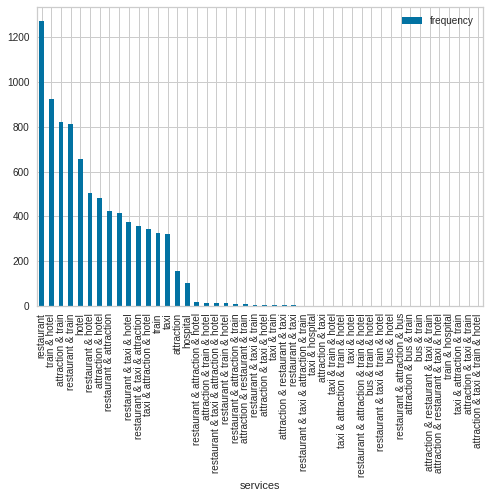

In [132]:
plot_services_from_dict(services_id)

empty service = 357

multi-service = 5525

2+ services = 1496

3+ services = 34

3 services = 1462

sample k items from each of the services in sampled_services_id dict

In [133]:

"""
  choices: sampling with replacement(repetition)
  sample: sampling without replacement(no repetition)
"""

k = 200
sampled_services_id = {}

for service in services_id:
  if len(services_id[service]) > 100:
    sampled_services_id[service] = choices(services_id[service], k=k)


 distribution of dialogues count after sampling


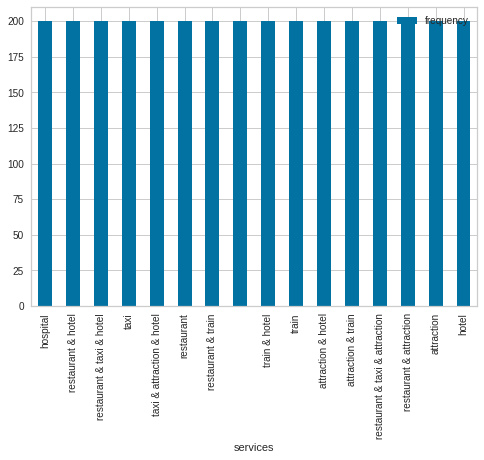

In [134]:
plot_services_from_dict(sampled_services_id)

dictionary of ids for easy acessability

In [135]:
dialogue_ids_dict = {}
for service in sampled_services_id:
  for id in sampled_services_id[service]:
    dialogue_ids_dict[id] = service


### Extracting texts from the sampled dialogues

In [136]:
path = "MultiWOZ-Clustering/train"
file_list = os.listdir(path)

dialogues = []

for file in file_list:
  with open(f'{path}/{file}') as f:

    data = json.load(f)
    for item in data:
      dialogue_id = item["dialogue_id"]
      if dialogue_id in dialogue_ids_dict:
        utterance_count = len(item['turns'])
        for idx, turn in enumerate(item['turns']):
          next_utterance_id =  f'{idx+1}-{dialogue_id[:-5]}' if idx < utterance_count - 1 else ""

          dialogues.append({
              "dialogue_id" : dialogue_id[:-5],
              "services": dialogue_ids_dict[dialogue_id],
              "services_list" : item["services"],
              "utterance_no": idx, 

              "utterance_id" : f'{idx}-{dialogue_id[:-5]}', 
              "next_utterance_id": next_utterance_id,
              
              "speaker" : turn['speaker'],
              "text" : turn['utterance'],
              "cleaned_text" : clean(turn['utterance'])
              })

df = pd.DataFrame(dialogues)

In [137]:
df

,dialogue_id,services,services_list,utterance_no,utterance_id,next_utterance_id,speaker,text,cleaned_text
0,SNG02022,hospital,[hospital],0,0-SNG02022,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...
1,SNG02022,hospital,[hospital],1,1-SNG02022,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712
2,SNG02022,hospital,[hospital],2,2-SNG02022,3-SNG02022,USER,Thank you Goodbye,thank you goodbye
3,SNG02022,hospital,[hospital],3,3-SNG02022,,SYSTEM,Have a wonderful day!,have a wonderful day
4,PMUL4452,restaurant & taxi & hotel,"[restaurant, taxi, hotel]",0,0-PMUL4452,1-PMUL4452,USER,I am traveling to Cambridge and looking forwar...,i am traveling to cambridge and looking forwar...
...,...,...,...,...,...,...,...,...,...
33319,MUL2568,taxi & attraction & hotel,"[taxi, attraction, hotel]",15,15-MUL2568,16-MUL2568,SYSTEM,I have booked a car from the acorn to country ...,i have booked a car from the acorn to country ...
33320,MUL2568,taxi & attraction & hotel,"[taxi, attraction, hotel]",16,16-MUL2568,17-MUL2568,USER,No that was it. Thanks for your help!,no that was it thanks for your help
33321,MUL2568,taxi & attraction & hotel,"[taxi, attraction, hotel]",17,17-MUL2568,18-MUL2568,SYSTEM,So glad that I could assist. Please call again.,so glad that i could assist please call again
33322,MUL2568,taxi & attraction & hotel,"[taxi, attraction, hotel]",18,18-MUL2568,19-MUL2568,USER,Ok. Good bye!,ok good bye


In [149]:
df.to_csv("dialogues_200_with_replacement.csv")

In [ ]:
df = pd.read_csv("/content/MultiWOZ-Clustering/dialogues_200_with_replacement.csv")
df.fillna('', inplace=True)
df

,Unnamed: 0,dialogue_id,services,services_list,utterance_no,utterance_id,next_utterance_id,speaker,text,cleaned_text
0,0,SNG02022,hospital,['hospital'],0,0-SNG02022,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...
1,1,SNG02022,hospital,['hospital'],1,1-SNG02022,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712
2,2,SNG02022,hospital,['hospital'],2,2-SNG02022,3-SNG02022,USER,Thank you Goodbye,thank you goodbye
3,3,SNG02022,hospital,['hospital'],3,3-SNG02022,NaN,SYSTEM,Have a wonderful day!,have a wonderful day
4,4,SNG01863,taxi,['taxi'],0,0-SNG01863,1-SNG01863,USER,I'm at Kettle's Yard and need a taxi to pick m...,i m at kettle s yard and need a taxi to pick m...
...,...,...,...,...,...,...,...,...,...,...
33277,33277,MUL2662,attraction & hotel,"['attraction', 'hotel']",15,15-MUL2662,16-MUL2662,SYSTEM,"Yes, several. The ADC Theatre, the Cambridge A...",yes several the adc theatre the cambridge arts...
33278,33278,MUL2662,attraction & hotel,"['attraction', 'hotel']",16,16-MUL2662,17-MUL2662,USER,"Yes, Can I have the post code and entrance fee...",yes can i have the post code and entrance fee ...
33279,33279,MUL2662,attraction & hotel,"['attraction', 'hotel']",17,17-MUL2662,18-MUL2662,SYSTEM,"Postal is cb58as, I do not have inform on the ...",postal is cb58as i do not have inform on the e...
33280,33280,MUL2662,attraction & hotel,"['attraction', 'hotel']",18,18-MUL2662,19-MUL2662,USER,"Ok perfect, that is all that I needed. Thank y...",ok perfect that is all that i needed thank you...


# Clustering

## USER utterances only

* here I extracted and clustered only the utterances of USER. 

In [139]:
cleaned_texts_user = list(df.loc[df['speaker'] == "USER", 'cleaned_text'])

embeddings_user = embed(cleaned_texts_user)


['hi i d like a guesthouse in the expensive range',
 'i told you tuesday can i speak to a manager you are not paying attention',
 'yes a different hotel in the same price range would be fine',
 'may i please have the price for this train',
 'it should be in the centre and be on the expensive side',
 'as long as it is a hotel and not any other type then yes book it for me',
 'that will be all thank you',
 'the train should arrive by 2015',
 'what are some places to go to',
 'i am looking for something expensive if the taj is expensive i would like to make a reservation there for 8 people on thursday at 1400',
 'how about at 1345',
 'i need the train for saturday and i m going to cambridge',
 'actually i also need a chinese restaurant',
 'i need a taxi to commute from the hotel to the college leaving the hotel at 2215',
 'i think that s all i need for today thank you so much for all your help',
 'i want to be picked up from lan hong house and taken to great saint mary s church please',
 

In [160]:
test_utterances = choices(cleaned_texts_user, k = 20)

show_top_5_similar_embeddings(embeddings_user, cleaned_texts_user, test_utterances)

Utterance: i am looking to stay at a guesthouse with free wfii
Top 5: 
0.7069190144538879 i m also looking for a guesthouse with free parking
0.7115686535835266 i am looking for a guesthouse that has free wifi
0.7216891050338745 i am looking for a guesthouse with free parking
0.7415493130683899 can you help me find a guesthouse with free wifi to stay at
0.7529205679893494 i m looking for a guesthouse to stay at with free wifi please

Utterance: yes please 1800 on wednesday for just myself
Top 5: 
0.7042981386184692 yes please there are 6 of us make it for 1700 on thursday
0.7307835817337036 yes please for 1 person at 1730 on thursday
0.7415599226951599 sure i would like that it ll be fore 2 people at 1800 on tuesday
0.752322793006897 yes please for sunday at 1800
0.7538947463035583 yes please 6 guests at 1800 on wednesday

Utterance: i m looking to stay at a moderate priced place with free parking
Top 5: 
0.7852964997291565 i m looking for a place that is moderately priced and has free

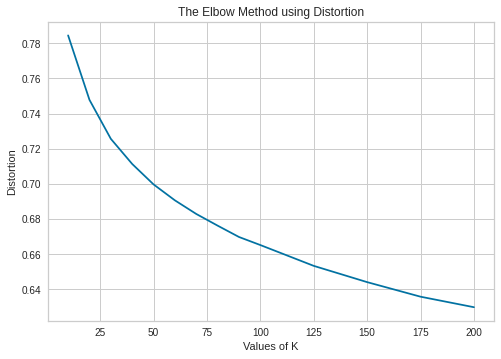

In [141]:
k = [10, 20, 30, 40, 50, 60, 70 ,80, 90,100,125,150,175,200]

distortion(embeddings_user, k)

Total WCE: 7500.196248996842
Total Cluster: 125 
Total count of uttarance in Clusters:16662


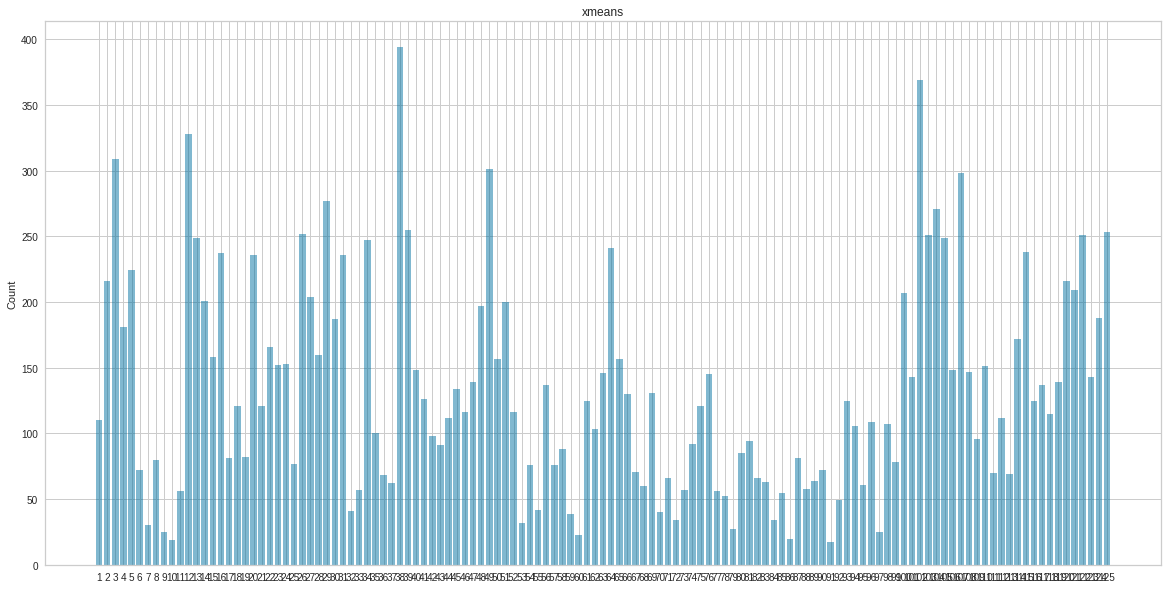

CPU times: user 58.5 s, sys: 181 ms, total: 58.7 s
Wall time: 58.5 s


In [142]:
%%time
number_of_clusters = 125
clusters_user, centers_user = xmeans_clustering(embeddings_user, number_of_clusters)

In [143]:
items_to_show_per_cluster = 30

print_cluster_items(clusters_user, cleaned_texts_user, items_to_show_per_cluster)



Cluster No: 0	 Count: [110]

77 the centre please
147 moderately priced in the centre of town
181 the centre please
219 is that in the centre
313 in the centre please
957 i would also like to visit a college in the centre
1166 i also need an expensive lodging in the center of town
1323 yes the centre is where i will be staying
1759 is this in the centre i d like something in the centre if possible
1872 i need something is the center area of town
1963 i want one in the centre
2028 do you have anything in the centre area
2105 i d prefer the centre please
2121 in the centre would be perfect
2392 i wanted to visit the center could you tell the the hours it is open
2590 there are none in the entire city center
2602 i need one in the centre does nt matter which
2716 i would like it to be in the centre
2915 in the centre as well please
3097 i m in the centre of town
3267 i will be visiting the centre
4003 i would prefer the centre
4107 yes i d like something cheap in the centre
4119 in the 

In [144]:
user_clusters_combined = clustering_clusters(centers_user, clusters_user)

user_text_clusters_id = {} #it will be used later

for idx, c in enumerate(user_clusters_combined):
  for i in c:
    user_text_clusters_id[cleaned_texts_user[i]] = f'u-{idx}'

# system utterances only

In [145]:
cleaned_texts_system = list(df.loc[df['speaker'] == "SYSTEM", 'cleaned_text'])

embeddings_system = embed(cleaned_texts_system)

In [161]:
test_utterances = test_utterances = choices(cleaned_texts_system, k = 20)

show_top_5_similar_embeddings(embeddings_system, cleaned_texts_system, test_utterances)

Utterance: what day are you traveling and what is your destination
Top 5: 
0.8512983322143555 what day would you be traveling and where are you going to
0.8513992428779602 on what day do you wish to travel and to what destination
0.8552616834640503 certainly what is your destination and what day will you be leaving
0.8590325713157654 okay where is the destination and what day would you like to travel
0.9511547684669495 what is your destination and what day are you hoping to travel

Utterance: well riverboat georgina is in the north
Top 5: 
0.6727368831634521 the riverboat georgina would work it s in the north do you need more information
0.6759232878684998 the riverboat georgina in a boating place and is in the north
0.7117735743522644 there is the riverboat georgina in the north would you like the information for it
0.7224326729774475 i have a listing for riverboat georgina in the north is that okay
0.765608549118042 riverboat georgina is in the north do you want their information

Ut

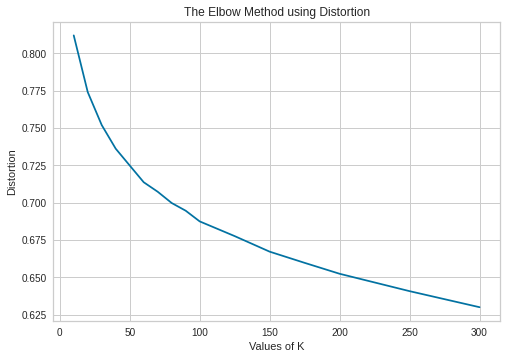

In [148]:
k = [10, 20, 30, 40, 50, 60, 70 ,80, 90,100,125,150,175,200,250,300]

distortion(embeddings_system, k)

Total WCE: 8111.972259497778
Total Cluster: 125 
Total count of uttarance in Clusters:16641


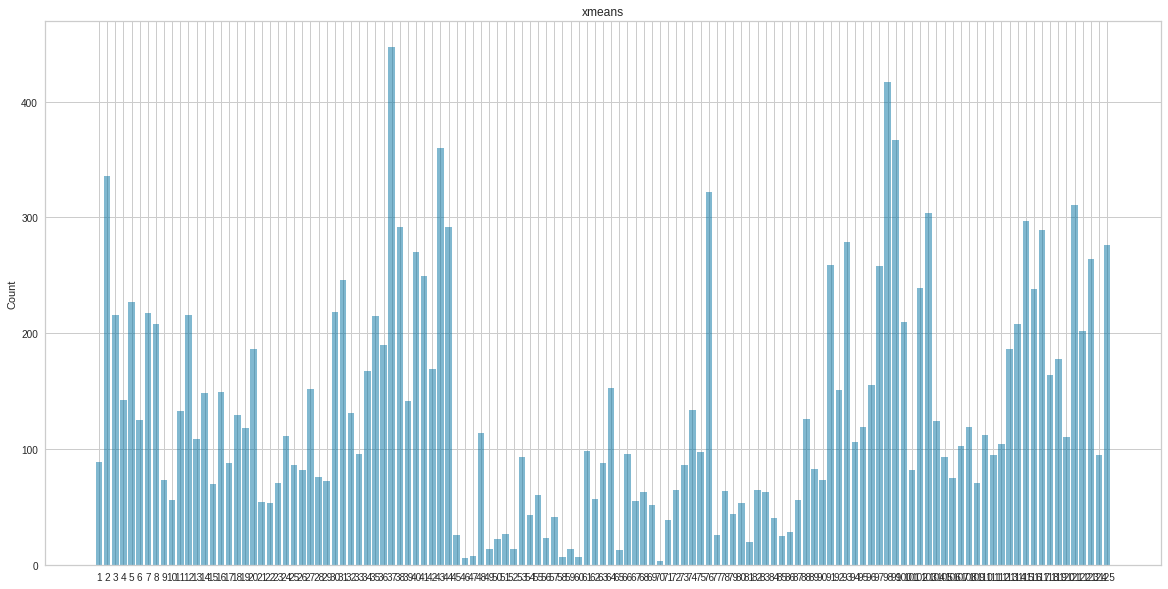

CPU times: user 1min 12s, sys: 196 ms, total: 1min 12s
Wall time: 1min 12s


In [ ]:
%%time
number_of_clusters = 125
clusters_system, centers_system = xmeans_clustering(embeddings_system, number_of_clusters)

In [ ]:
items_to_show_per_cluster = 30

print_cluster_items(clusters_system, cleaned_texts_system, items_to_show_per_cluster)



Cluster No: 0	 Count: [89]

4 your booking is complete a red ford will be picking you up
24 i have completed your booking the car type is a white volkswagen and the contact number is 07027624842
159 booking completed booked car type black volkswagen contact number 07559655717 can i help you with anything else today
189 your room is booked ref dosetwfu and a red audi will pick you up and get you to the restaurant for that reservation contact number 07840525996
428 booking completed booked car type black bmw contact number 07539045657
1290 booked car type black bmw contact number 07798470642
1579 your booking is complete a red toyota will be picking you up
1618 booking completed booked car type red lexus contact number 07029440032
1677 your booking is complete you will have a grey toyota and the contact number is07579620224
1966 booking completed anything else i can help with today booked car type grey volkswagen contact number 07966585521
2365 booked car type black skoda contact numbe

In [ ]:
system_clusters_combined = clustering_clusters(centers_system, clusters_system )


system_text_clusters_id = {}

for idx, c in enumerate(system_clusters_combined):
  for i in c:
    system_text_clusters_id[cleaned_texts_system[i]] = f's-{idx}'



Creating df of Nodes

In [150]:
user_nodes = save_nodes_with_n_utterances("u", 10, user_clusters_combined, cleaned_texts_user)

system_nodes = save_nodes_with_n_utterances("s", 10, system_clusters_combined, cleaned_texts_system)

In [ ]:
nodes = {**user_nodes , **system_nodes}


In [ ]:
nodes_df = pd.Series(nodes).to_frame('utterenaces')
#nodes_df = pd.DataFrame.from_dict(nodes, orient='index')
#nodes_df = nodes_df.T
nodes_df.to_csv("nodes_USE_with_10_utterances.csv")
nodes_df

,utterenaces
u-0,[thank you i also need a swimming pool in the ...
u-1,"[yes how long is the travel time, that works c..."
u-2,[the train will be leaving cambridge and going...
u-3,[okay i m looking for a train that departs fro...
u-4,[i m going to be leaving birmingham new street...
...,...
s-73,[we have 19 that match your search now do you ...
s-74,[i d recommend jesus green outdoor pool would ...
s-75,[there are no boats on the west side of town r...
s-76,[there are many things to do in town is there ...


# Getting Clusters and Edges

In [ ]:
def get_cluste_id(text, speaker):

  if speaker == "USER":
    return user_text_clusters_id[text] if text in user_text_clusters_id else "User No Cluster"   

  elif speaker == "SYSTEM":
    return system_text_clusters_id[text] if text in system_text_clusters_id else "System No Cluster"

In [ ]:
df["cluster_id"] = df.apply(lambda x: get_cluste_id(x['cleaned_text'].strip(),  x['speaker']) , axis=1)

In [ ]:
df

,Unnamed: 0,dialogue_id,services,services_list,utterance_no,utterance_id,next_utterance_id,speaker,text,cleaned_text,cluster_id
0,0,SNG02022,hospital,['hospital'],0,0-SNG02022,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...,u-30
1,1,SNG02022,hospital,['hospital'],1,1-SNG02022,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712,s-57
2,2,SNG02022,hospital,['hospital'],2,2-SNG02022,3-SNG02022,USER,Thank you Goodbye,thank you goodbye,u-46
3,3,SNG02022,hospital,['hospital'],3,3-SNG02022,NaN,SYSTEM,Have a wonderful day!,have a wonderful day,s-45
4,4,SNG01863,taxi,['taxi'],0,0-SNG01863,1-SNG01863,USER,I'm at Kettle's Yard and need a taxi to pick m...,i m at kettle s yard and need a taxi to pick m...,u-9
...,...,...,...,...,...,...,...,...,...,...,...
33277,33277,MUL2662,attraction & hotel,"['attraction', 'hotel']",15,15-MUL2662,16-MUL2662,SYSTEM,"Yes, several. The ADC Theatre, the Cambridge A...",yes several the adc theatre the cambridge arts...,s-62
33278,33278,MUL2662,attraction & hotel,"['attraction', 'hotel']",16,16-MUL2662,17-MUL2662,USER,"Yes, Can I have the post code and entrance fee...",yes can i have the post code and entrance fee ...,u-56
33279,33279,MUL2662,attraction & hotel,"['attraction', 'hotel']",17,17-MUL2662,18-MUL2662,SYSTEM,"Postal is cb58as, I do not have inform on the ...",postal is cb58as i do not have inform on the e...,s-61
33280,33280,MUL2662,attraction & hotel,"['attraction', 'hotel']",18,18-MUL2662,19-MUL2662,USER,"Ok perfect, that is all that I needed. Thank y...",ok perfect that is all that i needed thank you...,u-47


In [ ]:
df = df.set_index('utterance_id')

In [ ]:
df

,Unnamed: 0,dialogue_id,services,services_list,utterance_no,next_utterance_id,speaker,text,cleaned_text,cluster_id,next_utterance_cluster_id
utterance_id,,,,,,,,,,,
0-SNG02022,0,SNG02022,hospital,['hospital'],0,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...,u-30,s-57
1-SNG02022,1,SNG02022,hospital,['hospital'],1,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712,s-57,u-46
2-SNG02022,2,SNG02022,hospital,['hospital'],2,3-SNG02022,USER,Thank you Goodbye,thank you goodbye,u-46,s-45
3-SNG02022,3,SNG02022,hospital,['hospital'],3,,SYSTEM,Have a wonderful day!,have a wonderful day,s-45,None
0-SNG01863,4,SNG01863,taxi,['taxi'],0,1-SNG01863,USER,I'm at Kettle's Yard and need a taxi to pick m...,i m at kettle s yard and need a taxi to pick m...,u-9,s-9
...,...,...,...,...,...,...,...,...,...,...,...
15-MUL2662,33277,MUL2662,attraction & hotel,"['attraction', 'hotel']",15,16-MUL2662,SYSTEM,"Yes, several. The ADC Theatre, the Cambridge A...",yes several the adc theatre the cambridge arts...,s-62,u-56
16-MUL2662,33278,MUL2662,attraction & hotel,"['attraction', 'hotel']",16,17-MUL2662,USER,"Yes, Can I have the post code and entrance fee...",yes can i have the post code and entrance fee ...,u-56,s-61
17-MUL2662,33279,MUL2662,attraction & hotel,"['attraction', 'hotel']",17,18-MUL2662,SYSTEM,"Postal is cb58as, I do not have inform on the ...",postal is cb58as i do not have inform on the e...,s-61,u-47


In [ ]:
df["next_utterance_cluster_id"] = df.apply(lambda x: df.loc[x['next_utterance_id']]["cluster_id"] if x['next_utterance_id'] != "" else None,  axis=1)

In [ ]:
df.to_csv("dialogue_clusters_USE_200_with_replacement.csv")

In [ ]:
df_edges = df[["cluster_id", "next_utterance_cluster_id"]]
df_edges = df_edges.dropna()
df_edges.columns = ['Source', 'Target']

df_edges

,Source,Target
utterance_id,,
0-SNG02022,u-30,s-57
1-SNG02022,s-57,u-46
2-SNG02022,u-46,s-45
0-SNG01863,u-9,s-9
1-SNG01863,s-9,u-6
...,...,...
14-MUL2662,u-34,s-62
15-MUL2662,s-62,u-56
16-MUL2662,u-56,s-61


In [ ]:
df_edges.to_csv("edges_USE_200_with_replacement.csv")

In [ ]:
df_edges_weights = df_edges.groupby(['Source','Target']).size().reset_index().rename(columns={0:'Weight'})
df_edges_weights


,Source,Target,Weight
0,s-0,u-10,3
1,s-0,u-11,1
2,s-0,u-46,13
3,s-0,u-47,45
4,s-0,u-50,1
...,...,...,...
3305,u-9,s-73,2
3306,u-9,s-75,1
3307,u-9,s-77,2
3308,u-9,s-8,46


In [ ]:
df_edges_weights.to_csv("edges_weight_USE_200_with_replacement.csv")